In [1]:
import numpy as np
from scipy.integrate import odeint
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter


# 1.1 Simulation


In [2]:
def pendulum_rhs(y, t, alpha, mu):
    z, dz = y
    return [dz, -mu * np.sin(z) - alpha * np.abs(dz)*dz]

In [3]:
def simulate_pendulum(num, dt, z0, dz0, alpha, mu):
    t = np.linspace(0, num*dt, num)
    return odeint(pendulum_rhs, [z0, dz0], t, args=(alpha, mu)), np.array([t])
    

In [4]:
def generate_phase_portrait_grid(num, dt, alpha, mu, n):
    z = np.linspace(-1, 1, n)
    dz = np.linspace(-1, 1, n)
    fig, axs = plt.subplots(n, n)
    plt.suptitle(fr"Phase portait with parameters: t: {num*dt}s, ic $\in [-1, 1]^2$ $\alpha$: {alpha}, $\mu$: {mu}")
    for i in range(n):
        for j in range(n):
            z0 = z[i]
            dz0 = dz[j]
            z, dz = simulate_pendulum(num, dt, z0, dz0, alpha, mu)[0].T
            axs[i,j].plot(z, dz)
    fig.text(0.5, 0.01, 'z', ha='center')
    fig.text(0.01, 0.5, 'dz', va='center', rotation='vertical')
    
    plt.tight_layout()


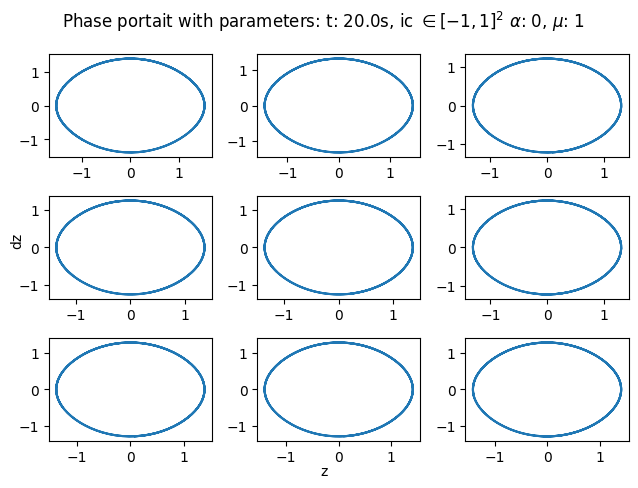

In [5]:
generate_phase_portrait_grid(200, 0.1,0, 1, 3)

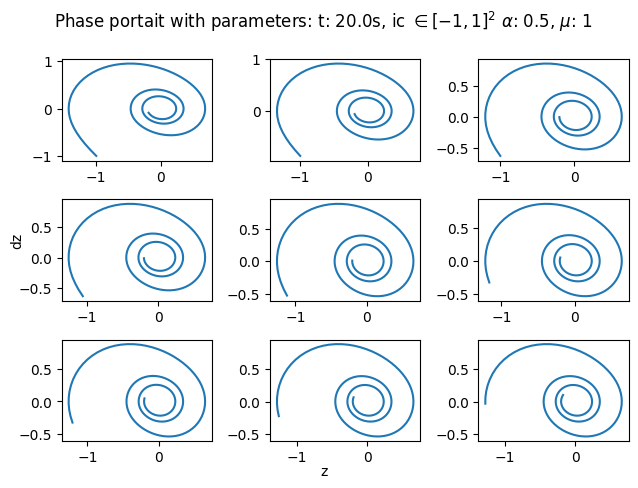

In [10]:
generate_phase_portrait_grid(200, 0.1, 0.5, 1, 3)

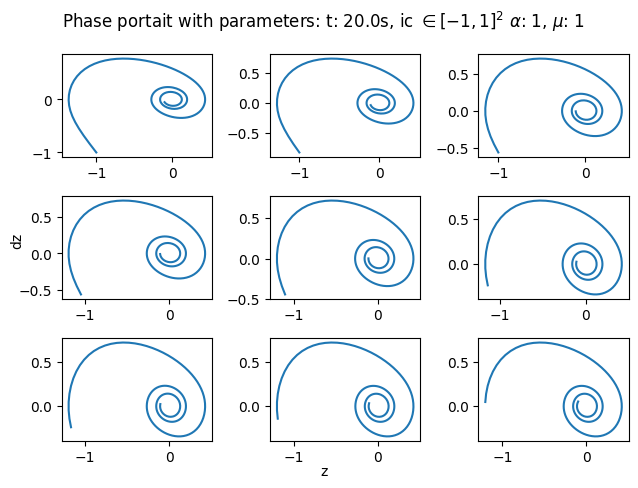

In [11]:
generate_phase_portrait_grid(200, 0.1, 1, 1, 3)

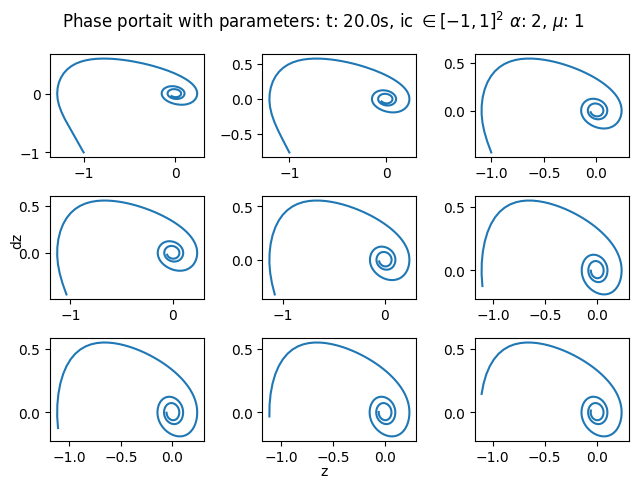

In [12]:
generate_phase_portrait_grid(200, 0.1, 2, 1, 3)

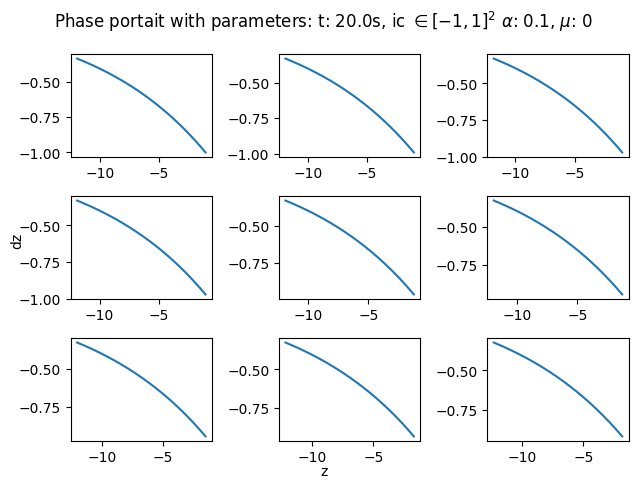

In [13]:
generate_phase_portrait_grid(200, 0.1, 0.1, 0, 3)

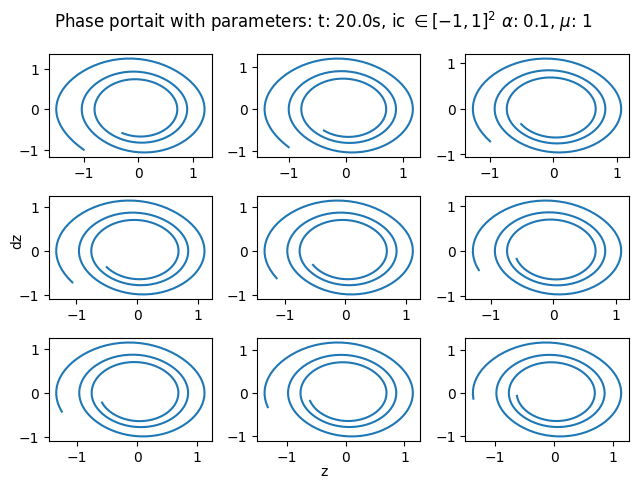

In [14]:
generate_phase_portrait_grid(200, 0.1, 0.1, 1, 3)

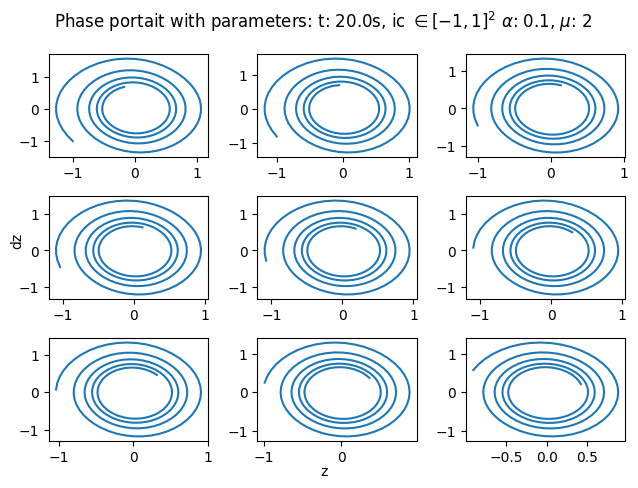

In [15]:
generate_phase_portrait_grid(200, 0.1, 0.1, 2, 3)

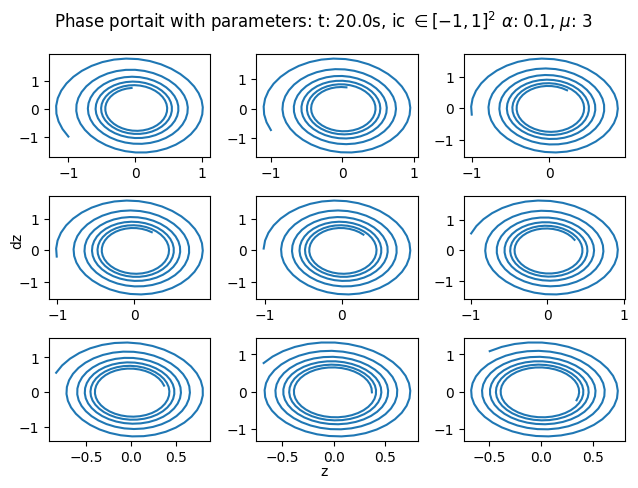

In [16]:
generate_phase_portrait_grid(200, 0.1, 0.1, 3, 3)

# 1.2

In [956]:
class PINN(nn.Module):
    def __init__(self, input_size, output_size, number_of_layers, layer_size, activation_function, rhs):
        super().__init__()
        self.layers = [nn.Linear(input_size, layer_size)]
        
        for n in range(number_of_layers):
            self.layers.append(nn.Linear(layer_size, layer_size))
            self.layers.append(activation_function())
        
        self.layers.append(nn.Linear(layer_size, output_size))
        
        self.layers = nn.Sequential(*self.layers)
        self.rhs = rhs
        self.criterion = nn.MSELoss()
        
        self.lambda_ode = 1
        self.lambda_data = 0
    
    def forward(self, T):
        T = T.reshape(-1, 1)
        return torch.sin(self.layers(T))
    
    def f(self, t: torch.Tensor) -> torch.Tensor:
        return functional_call(model, tuple(model.parameters()), (t, ))
    

    
    
    def loss_ODE(self, T):
        x = self.forward(T)
        dx = self.forward(T)[:, 1]
        print(x.shape)
        #dx = self.rhs(x, _).T
        
        x.backward(torch.tensor([[1] + 63 * [0], [1] + 63 * [0]]).T, retain_graph=True)
        print(x.grad)
        
        #return self.criterion(x, dx)
    
    def loss_data(self, X0, T0):
        return self.criterion(self.forward(T0), X0)
    
    def total_loss(self, T, CPs):
        X_ic = CPs[1:] 
        T_ic = CPs[0]
        loss_ODE = self.loss_ODE(T)
        loss_data = self.loss_data(X_ic, T_ic)
        return self.lambda_ode * loss_ODE  + self.lambda_data * loss_data, torch.autograd.grad(loss_data, self.parameters(), retain_graph=True)[0], torch.autograd.grad(loss_ODE, self.parameters(), retain_graph=True)[0]
    
        
        
    
            
        
        
    

In [957]:
def train_pinn(model, t, train_data, num_cps, num_epochs, split_size, lr=0.001):
    writer = SummaryWriter()
    data = np.hstack((t.T, train_data))
    
    X = torch.FloatTensor(data)
    dataset = TensorDataset(X)
    data_loader = DataLoader(dataset, batch_size=split_size, shuffle=False)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_list=[]
    for epoch in range(num_epochs):
        k = 0
        weights = [np.exp(0) for i in range(len(data_loader))]
        total_loss = 0
        for data in data_loader:
            input_times = data[0][:, 0]
            input_data = data[0][:, 1:]        
            CPs = data[0][0]
            loss, grad_data, grad_ode = model.total_loss(input_times, CPs)
            writer.add_scalar(f'RAW_LOSS/{k}',loss, epoch)
            loss = weights[k] * loss
            total_loss += loss

        
            #if epoch % 100 == 0:
            #    weights[k] = torch.exp(-total_loss + loss)
            #    writer.add_scalar(f'Weights/{k}', weights[k], epoch)
            #    writer.add_scalar(f'Cum Loss/{k}',-total_loss + loss, epoch)
        
       # if epoch % 100 == 0:

       #     grad = torch.norm(grad_data) + torch.norm(grad_ode)
       #     model.lambda_ode = 0.9 * model.lambda_ode + 0.1 * (grad / torch.norm(grad_ode))
       #     model.lambda_data = 0.9*model.lambda_data + 0.1 * (grad / torch.norm(grad_data))
       #     writer.add_scalar(f'L/ODE', model.lambda_ode, k)
       #     writer.add_scalar(f'L/data',model.lambda_data, k)
       #     
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            k += 1


        loss_list.append(loss.item())

    return loss_list
    
   

In [958]:
alpha = 0.1
mu = 1
data_train, t = simulate_pendulum(400, 0.1, 0, 0.9, alpha, mu)

In [959]:
model = PINN(1, 2, 1, 256, nn.GELU, lambda y, t: torch.FloatTensor(pendulum_rhs(y.detach().numpy().T, t, alpha, mu)))

In [960]:
loss_list = train_pinn(model, t, data_train,400, 500, 64)

torch.Size([64, 2])
None


C:\Users\Florian\AppData\Local\Temp\ipykernel_14264\4146226390.py:36: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten\src\ATen/core/TensorBody.h:494.)
  print(x.grad)


TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

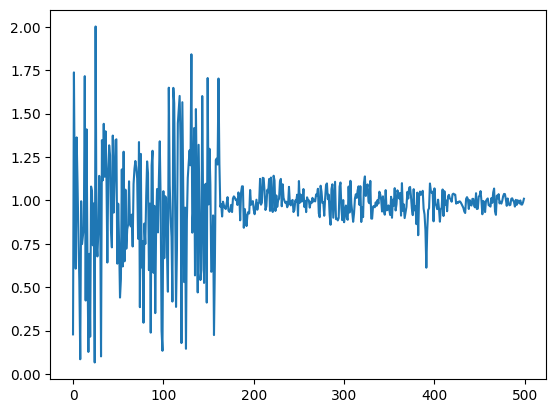

In [955]:
plt.plot(loss_list)

In [784]:
T = torch.FloatTensor(t)
X = model.forward(T)
X = X.detach().numpy()

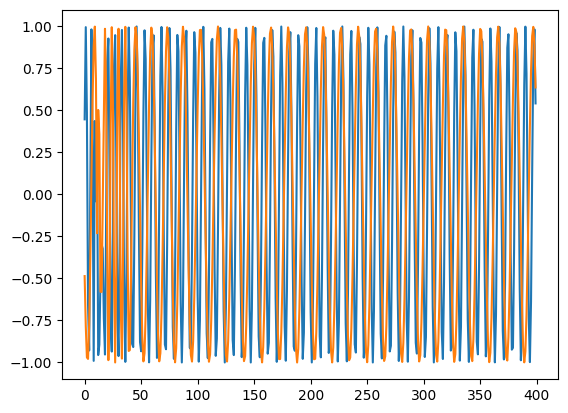

In [785]:
plt.plot(X)

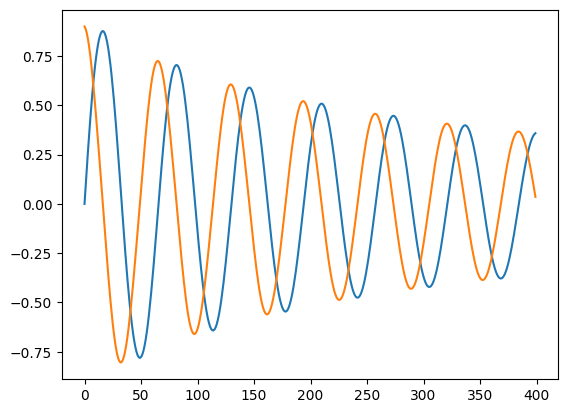

In [786]:
plt.plot(data_train)

In [893]:
import torch
from torch.autograd import Variable

# Define your input tensor
input_tensor = torch.tensor([[1.0, 2.0, 3.0]], requires_grad=True)

# Define your computation graph
output_tensor = input_tensor ** 2

# Compute gradients
output_tensor.backward(torch.tensor([[1.0, 0.0, 0.0]]), retain_graph=True)
gradient = input_tensor.grad

print("Gradient with respect to input:", gradient)

Gradient with respect to input: tensor([[2., 0., 0.]])


In [967]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad

# Define the pendulum dynamics
def pendulum_rhs(z, dz, alpha, mu):
    ddz = -mu * torch.sin(z) - alpha * torch.abs(dz) * dz
    return ddz

# Define the loss function
def loss_fn(z, dz, alpha, mu):
    z.requires_grad_(True)
    dz.requires_grad_(True)
    
    ddz = pendulum_rhs(z, dz, alpha, mu)
    loss = dz ** 2 - ddz
    return torch.mean(dz ** 2)



# Generate training data
n_samples = 100
theta_train = torch.rand(n_samples) * np.pi  # Random initial angle
theta_dot_train = torch.rand(n_samples) - 0.5  # Random initial angular velocity

# Define the neural network
class PINN(torch.nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = torch.nn.Linear(2, 10)
        self.fc2 = torch.nn.Linear(10, 10)
        self.fc3 = torch.nn.Linear(10, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize PINN model
model = PINN()

# Training loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 1000
for epoch in range(n_epochs):
    # Forward pass
    inputs = torch.stack([theta_train, theta_dot_train], dim=1)
    outputs = model(inputs)
    
    # Compute loss
    loss = loss_fn(theta_train, theta_dot_train, 0, 1)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print progress
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

model.forward(torch.FloatTensor([1, 0]))


Epoch [100/1000], Loss: 0.0968
Epoch [200/1000], Loss: 0.0968
Epoch [300/1000], Loss: 0.0968
Epoch [400/1000], Loss: 0.0968
Epoch [500/1000], Loss: 0.0968
Epoch [600/1000], Loss: 0.0968
Epoch [700/1000], Loss: 0.0968
Epoch [800/1000], Loss: 0.0968
Epoch [900/1000], Loss: 0.0968
Epoch [1000/1000], Loss: 0.0968


tensor([0.3418], grad_fn=<ViewBackward0>)

In [971]:
-np.sin(1)

-0.8414709848078965

In [972]:
import torch
import torch.nn as nn
import torch.optim as optim

class PNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the pendulum dynamics
def pendulum_dynamics(theta, theta_dot, length, gravity):
    theta_ddot = -gravity / length * torch.sin(theta)
    return theta_dot, theta_ddot

# Generate training data
def generate_data(n_samples, length, gravity):
    t = torch.linspace(0, 10, n_samples)
    theta = torch.sin(t)
    theta_dot = torch.cos(t)
    theta_ddot = -gravity / length * torch.sin(theta)
    return t.unsqueeze(1), torch.stack([theta, theta_dot, theta_ddot], dim=1)

# Train the model
def train_model(model, optimizer, criterion, t, true_states):
    optimizer.zero_grad()
    predicted_states = model(t)
    loss = criterion(predicted_states, true_states)
    loss.backward()
    optimizer.step()
    return loss.item()

# Initialize parameters
length_true = 1.0
gravity_true = 9.81
input_size = 1  # Input: time
output_size = 2  # Output: position and velocity
hidden_size = 10

# Generate training data
n_samples = 100
t_train, true_states_train = generate_data(n_samples, length_true, gravity_true)

# Initialize PNN model
model = PNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
n_epochs = 1000
for epoch in range(n_epochs):
    loss = train_model(model, optimizer, criterion, t_train, true_states_train)
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss:.4f}')

# Test the model
t_test, true_states_test = generate_data(n_samples, length_true, gravity_true)
predicted_states_test = model(t_test)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(t_test, true_states_test[:, 0], label='True Position')
plt.plot(t_test, predicted_states_test[:, 0].detach().numpy(), label='Predicted Position')
plt.plot(t_test, true_states_test[:, 1], label='True Velocity')
plt.plot(t_test, predicted_states_test[:, 1].detach().numpy(), label='Predicted Velocity')
plt.xlabel('Time')
plt.ylabel('State')
plt.title('Pendulum Dynamics Prediction')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\Florian\anaconda3\envs\python3-env\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([100, 3])) that is different to the input size (torch.Size([100, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 1